In [24]:
import threading as th

import numpy as np

import matplotlib.pyplot as plt

import cv2
from sklearn import metrics
from tqdm import tqdm

import math

In [2]:
!pip3 install gdown

In [4]:
!gdown --id 142ZDieGzn97X5AUi5frjS121x7po59lw

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=142ZDieGzn97X5AUi5frjS121x7po59lw
To: /kaggle/working/mona.jpg
100%|██████████████████████████████████████| 12.1k/12.1k [00:00<00:00, 10.7MB/s]


In [5]:
img = cv2.imread('/kaggle/working/mona.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [6]:
!lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          4
On-line CPU(s) list:             0-3
Thread(s) per core:              2
Core(s) per socket:              2
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2199.998
BogoMIPS:                        4399.99
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:                       64 KiB
L1i cache:                       64 KiB
L2 cache:                        512 KiB
L3 cache:                        55 MiB
NUMA node0 CPU(s):               0-3
Vulnerability 

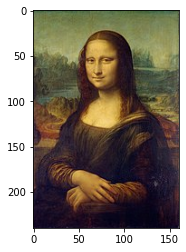

In [7]:
plt.imshow(img)

In [8]:
def random_circle():
    '''Function generating random circles.
    Cirlce is presented as a numpy array lenght 7 in such scheme
    [x, y, radius, opacity, r, g, b]

    Returns:
        circle (numpy array length 7): the generated circle
    '''
    return np.random.random(7)


In [9]:
def random_individual(chromosome_length, genotype=7):
    '''Function generating random individual.
    Args:
        chromosome_length (int): number of figures in an individual
        genotype (int): lenght of a gene (defaults 7 for circle)
    Returns:
        indiv (numpy array shaped (chromosome_length, genotype)): the generated individual
    '''
    indiv = np.zeros((chromosome_length, genotype))
    if genotype == 7:
        for i in range(chromosome_length):
            indiv[i] = random_circle()
    
    return indiv

In [10]:
def random_population(population_size, chromosome_length, genotype=7):
    '''Function generating random population.
    Args:
        population_size (int): number of individuals in the population
        chromosome_length (int): number of figures in and individual
        genotype (int): length of a gene (defaults 7 for circle)
    
    Returns:
        population: generated population
    '''
    population = np.zeros((population_size, chromosome_length, genotype))
    for i in range(population_size):
        population[i] = random_individual(chromosome_length, genotype)
    
    return population

In [11]:
def draw_circle(dst, gene):
    '''Function drawing circle from given genotype on given image.
    Args:
        dst: destination image
        gene: circle encoded as a single gene
    '''
    height, width = dst.shape[0], dst.shape[1]
    avg_radius = math.sqrt(height**2 + width**2)

    y = int(gene[1] * height)
    x = int(gene[0] * width)

    radius = int(gene[2] * avg_radius)
    color = (gene[4:7] * 255).astype(int).tolist()

    cv2.circle(dst, center=(y, x), radius=radius, color=color, thickness=-1)

In [12]:
def draw(dst, gene, figure="Cirlce"):
    '''Function drawing the given figure from given gene on dst image.
    Args:
        dst: destination image to draw the figure on
        gene: the single figure encoded as gene
        figure: string with figure type
    '''
    # drawing circles
    if figure == "Circle":
        draw_circle(dst, gene)

    # place for other figures

In [13]:
def get_population_phenotypes(population, width, height, figure="Circle"):
    '''Function transforming each individual in he population into phenotype.
    Args:
        population: current population
        width: width of the target img
        height: height of the target img
    Returns:
        phenotypes: an array with phenotypes of each individual in the population
    '''
    phenotypes = np.zeros((population.shape[0], height, width, 3))
    for i in range(population.shape[0]):
        phenotypes[i] = get_phenotype(population[i], width, height, figure=figure)
    
    return phenotypes

In [14]:
def get_phenotype(genotype, width, height, figure="Circle"):
    '''Function getting phenotype out of an individual.
    Args:
        genotype: single individual from the population (his genotype)
        width: width of the target image
        height: height of the target image
        figure: string with figure type in single genotype
    Returns:
        phenotype: phenotype of the given individual
    '''
    phenotype = np.zeros((height, width, 3))
    for gene in genotype:
        overlay = phenotype.copy()
        draw(overlay, gene, figure=figure)
        opacity = gene[-4]
        
        phenotype = cv2.addWeighted(overlay, opacity, phenotype, 1-opacity, 0)
    return phenotype

In [19]:
def get_phenotypes_threading(phenotypes, index, genotype, width, height, figure="Circle"):
    phenotypes[index] = get_phenotype(genotype, width, height, figure)

In [15]:
def MSE(phenotypes, target):
    return np.sum((phenotypes-target)**2, axis=(1,2,3)) / (target.shape[0]*target.shape[1])

In [16]:
img.shape

(240, 161, 3)

In [17]:
def mutate_population(population, width, height, sigma=0.1666, mut_prob=0.3):
    mutation_indices = (np.random.random(population.shape) < mut_prob).astype(float)
    population += mutation_indices * np.random.randn(*population.shape) * sigma
    population[:, :, 2:7] = np.clip(population[:, :, 2:7], [0], [1])
    return population

In [41]:
def show_image(img):
    plt.imshow(img/255)
    plt.show()

# ES

In [45]:
def es(objective_func, 
       chrom_length, 
       pop_size, 
       iters, 
       num_offspring, 
       num_parents, 
       sigma, 
       target_img,
       parallel=True):
    best_solution = np.empty((1, chrom_length, 7))
    best_solution_objective_value = 10^6

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((int(number_of_iterations/100), chromosome_length, 7))
    
    height, width = target_img.shape[0], target_img.shape[1]
    
    #generating random population
    current_population = random_population(pop_size, chromosome_length)
    indiv_shape = current_population.shape[1:]

    # evaluating the objective population on the current population
    current_population_phenotypes = np.empty((pop_size, height, width, 3))
    if parallel:        
        threads=[]
        for i in range(pop_size):
            t=th.Thread(target=get_phenotypes_threading, args=[current_population_phenotypes, i,
                                                            current_population[i], width, height])
            t.start()
            threads.append(t)
        for t in threads:
            t.join()
    else:
        current_population_phenotypes = get_population_phenotypes(current_population, width, height)
    current_population_objective_values = objective_func(current_population_phenotypes, target_img)

    for iteration in tqdm(range(iters)):
        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / pop_size * np.ones(pop_size)
        parent_indices = np.random.choice(pop_size, (num_offspring, num_parents), True, fitness_values).astype(np.int64)
    
        # creating the children population by Global Intermediere Recombination
        children_population = np.zeros((num_offspring, *indiv_shape))
        for i in range(num_offspring):
            children_population[i, :] = current_population[parent_indices[i, :], :].mean(axis=0)
        
        # mutating the children population
        children_population = mutate_population(children_population, width, height)

        # evaluating the objective function on the children population
        children_population_phenotypes = np.empty((num_offspring, height, width, 3))
        if parallel:        
            threads=[]
            for i in range(num_offspring):
                t=th.Thread(target=get_phenotypes_threading, args=[children_population_phenotypes, i,
                                                                children_population[i], width, height])
                t.start()
                threads.append(t)
            for t in threads:
                t.join()
        else:
            children_population_phenotypes = get_population_phenotypes(children_population, width, height)
        children_population_objective_values = objective_function(children_population_phenotypes, target_img)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population = np.vstack([current_population, children_population])
        current_population_phenotypes = np.vstack([current_population_phenotypes, children_population_phenotypes])

        I = np.argsort(current_population_objective_values)
        current_population = current_population[I[:pop_size], :]
        current_population_phenotypes = current_population_phenotypes[I[:pop_size], :]
        current_population_objective_values = current_population_objective_values[I[:pop_size]]

         # recording some statistics
        if best_solution_objective_value > current_population_objective_values[0]:
            best_solution = current_population[0, :]
            best_solution_objective_value = current_population_objective_values[0]
                
        log_objective_values[iteration, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        
        if np.mod(iteration, 1000) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (iteration, log_objective_values[:iteration+1, 0].min(), log_objective_values[iteration, 2]))
            log_best_solutions[iteration, :] = current_population[0, :]
            show_image(current_population_phenotypes[0])

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions

In [42]:
chromosome_length = 150
population_size = 10
number_of_iterations = 10000
number_of_offspring = 100
number_of_parents = 2
sigma = 1/6
objective_function = MSE

  0%|          | 0/10000 [00:00<?, ?it/s]

Iteration 0000 : best score = 10804.61599358, mean score = 13503.18160417.


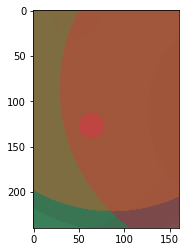

  0%|          | 2/10000 [00:08<12:09:41,  4.38s/it]


KeyboardInterrupt: 

In [46]:
#objective_func, chrom_length, pop_size, iters, num_offspring, num_parents, sigma, target_img
val, solution, log_vals, log_sols = es(MSE, 
                                       chromosome_length, 
                                       population_size, 
                                       number_of_iterations, 
                                       number_of_offspring, 
                                       number_of_parents, 
                                       sigma, 
                                       img, 
                                       False)

In [ ]:
print(f"best score: {val}")
plt.figure(figsize=(18, 4))
plt.plot(self.log_vals[:, 0], 'r-')
plt.plot(self.log_vals[:, 1], 'g-')
plt.plot(self.log_vals[:, 2], 'b-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()